# Solve Any Data Analysis Problem

## Chapter 12 - Project 8 Part 1 - example solution

Original data from: https://github.com/aliannejadi/LSApp

- recreate previous analysis steps
- find & drop duplicates
- enhance with ChatGPT categorisations
- do further analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Load in the data and try to recreate the original analysis

In [2]:
app_data = pd.read_csv(
    "./data/lsapp.tsv.gz",
    sep="\t",
    names=["user_id", "session_id", "timestamp",
           "app_name", "event_type"],
    parse_dates=["timestamp"],
    skiprows=1
)
print(app_data.shape)
app_data.head()

(3658590, 5)


,user_id,session_id,timestamp,app_name,event_type
0,0.0,1.0,2018-01-16 06:01:05,Minesweeper Classic (Mines),Opened
1,0.0,1.0,2018-01-16 06:01:05,Minesweeper Classic (Mines),Closed
2,0.0,1.0,2018-01-16 06:01:07,Minesweeper Classic (Mines),Opened
3,0.0,1.0,2018-01-16 06:01:07,Minesweeper Classic (Mines),Closed
4,0.0,1.0,2018-01-16 06:01:08,Minesweeper Classic (Mines),Opened


Metrics on first page said:

- 292 users
- 87 apps
- 8 months of events
- 3 event types (appendix says "broken" events were dropped, as were missing records)

Let's review missing data first.

In [3]:
app_data.isnull().sum()

user_id       1
session_id    1
timestamp     1
app_name      1
event_type    1
dtype: int64

Let's just drop that one row.

In [4]:
app_data = app_data.dropna()

Looking at the original data table, user ID and session ID look like decimal numbers but they should be integers. This should just be because `pandas` 1 doesn't have a nullable integer type. Now the missing data has been dropped, let's convert them to integers.

In [5]:
app_data.dtypes

user_id              float64
session_id           float64
timestamp     datetime64[ns]
app_name              object
event_type            object
dtype: object

user ID and session ID can be integers

In [6]:
app_data["user_id"] = app_data["user_id"].astype(int)
app_data["session_id"] = app_data["session_id"].astype(int)

app_data.dtypes

user_id                int32
session_id             int32
timestamp     datetime64[ns]
app_name              object
event_type            object
dtype: object

The slides said "broken" events were dropped, so let's investigate that before calculating anything else.

In [7]:
app_data["event_type"].value_counts(normalize=True)

Opened              0.457351
Closed              0.455644
User Interaction    0.085779
Broken              0.001226
Name: event_type, dtype: float64

"Broken" events make up 0.1% of our data. Let's see some example apps that had broken events:

In [8]:
app_data.loc[app_data["event_type"] == "Broken", "app_name"].value_counts()

Messages              2213
eBay                   398
Clock                  292
Messaging              257
Google Chrome          237
Pandora Music          194
Phone                  193
Facebook Messenger      75
Yahoo Mail              71
Calendar                60
WhatsApp Messenger      59
Samsung Email           56
Maps                    55
Gmail                   54
Google Drive            48
Facebook                45
Google Photos           31
Google Play Music       26
Robinhood               23
Telegram                21
Hangouts                18
Verizon Messages        16
Instagram               11
Telegram X               8
WeChat                   8
Podcast Addict           4
Microsoft Outlook        4
Discord                  3
TextNow                  3
Contacts                 2
Name: app_name, dtype: int64

Not enough context for what that means, so let's agree with the initial analysis and say these aren't relevant for us.

In [9]:
app_data = app_data[app_data["event_type"] != "Broken"]

How many users?

In [10]:
app_data["user_id"].nunique()

292

How many unique apps?

In [11]:
app_data["app_name"].nunique()

87

And date range?

In [12]:
app_data["timestamp"].agg(["min", "max"])

min   2017-09-09 17:16:06
max   2018-05-17 08:42:29
Name: timestamp, dtype: datetime64[ns]

Dates in an approx. 8 month range.

Let's recreate the charts as well.

First, the distribution of "sessions per user". For this, we need to count the number of sessions per user.

In [13]:
sessions_per_user = (
    app_data
    .groupby("user_id")
    ["session_id"]
    .nunique()    
)

sessions_per_user.describe()

count     292.000000
mean      261.113014
std       484.984555
min         1.000000
25%        45.750000
50%        95.500000
75%       289.000000
max      5153.000000
Name: session_id, dtype: float64

This varies from a user with a single session to a user with over 5000. But what is the full distribution?

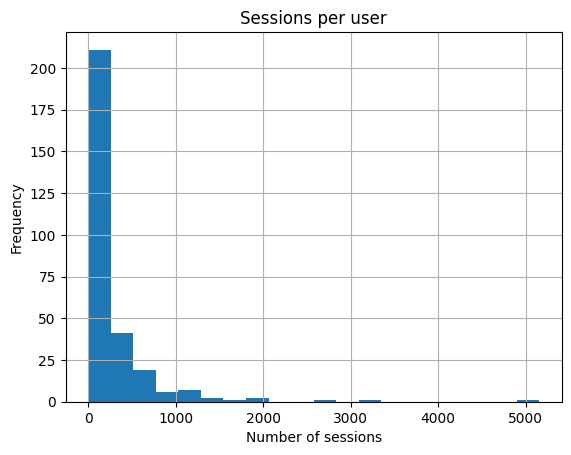

In [14]:
fig, axis = plt.subplots()

_ = sessions_per_user.hist(bins=20, ax=axis)

_ = axis.set(
    title="Sessions per user",
    xlabel="Number of sessions",
    ylabel="Frequency"
)

Classic situation where most users have few sessions with plenty of outliers. This was illustrated in the slides, as was the distribution limited to ~1000.

Let's see: what's the distribution under 1000?

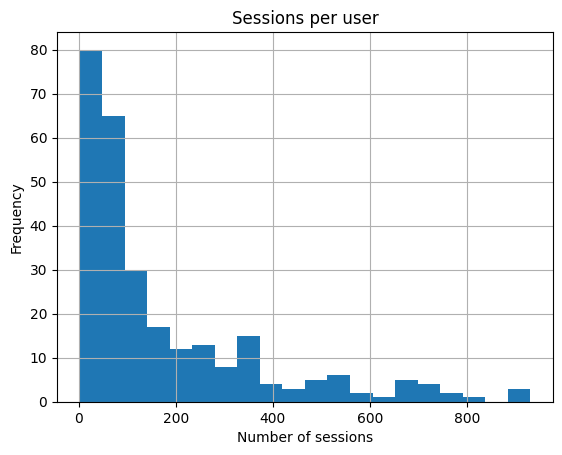

In [15]:
fig, axis = plt.subplots()

_ = sessions_per_user[sessions_per_user < 1000].hist(bins=20, ax=axis)

_ = axis.set(
    title="Sessions per user",
    xlabel="Number of sessions",
    ylabel="Frequency"
)

What about those extreme users?

In [16]:
sessions_per_user.sort_values(ascending=False).head(5)

user_id
138    5153
290    3284
192    2763
31     1885
204    1851
Name: session_id, dtype: int64

Let's investigate that user who has 5000 sessions.

In [17]:
app_data[app_data["user_id"] == 138].head(10)

,user_id,session_id,timestamp,app_name,event_type
1782158,138,28802,2018-01-04 05:21:59,Phone,Opened
1782159,138,28802,2018-01-04 05:21:59,Phone,Closed
1782160,138,28802,2018-01-04 05:21:59,Phone,Opened
1782161,138,28802,2018-01-04 05:22:25,Phone,Closed
1782162,138,28802,2018-01-04 05:22:26,Telegram,User Interaction
1782163,138,28802,2018-01-04 05:24:54,Telegram,User Interaction
1782164,138,28802,2018-01-04 05:28:53,Telegram,User Interaction
1782165,138,28802,2018-01-04 05:29:02,Facebook Messenger,Opened
1782166,138,28802,2018-01-04 05:30:02,Facebook Messenger,Closed
1782167,138,28803,2018-01-04 05:35:04,Twitter,User Interaction


We see some interesting things here:

- some apps are opened and closed immediately. Sometimes they're opened again after that. Is that important information?
- some apps are opened and closed for a second. Again, is that relevant information to keep?

Let's see how big this problem is. How many exact duplicates do we have?

In [18]:
len(app_data)

3654104

In [19]:
app_data.duplicated().sum() / len(app_data)

0.5974564489680644

Wow, that's 60% of the data that's an exact duplicate of another row. Same user, same session, same app, same action and same timestamp.

Is this a problem? Let's think of what we will want to calculate:

- when people use their phones. For this, duplicates will skew the results.
- what types of apps people use. If we count distinct app types, duplicates aren't an issue.

For at least one of our use cases duplicates are a problem.

So can we just drop duplicates? Looking at the first few rows for that user, we might run into a problem where we have two records for someone closing an app and only one for opening it.

We could stop looking at the event level and think only of browsing sessions.

We're interested in user behavior but not necessarily at the individual app level (e.g. how long each app is used for), so we could drop all "closed" events and see where that leaves us.

In [20]:
closed_dropped = app_data.loc[app_data["event_type"] != "Closed", :]

print(len(closed_dropped))
print(len(closed_dropped) / len(app_data))
print(closed_dropped.duplicated().sum() / len(closed_dropped))

1987090
0.543796783014386
0.5991560523177109


Removing "closed" events leaves us with just over half our initial data, but it's still 60% exact duplicates.

A duplicate now means we have multiple records to show a user opened an app within a session at the exact same time.

Let's drop those duplicates entirely as well.

In [21]:
app_data_reduced = closed_dropped.drop_duplicates()
len(app_data_reduced)

796513

In [22]:
app_data_reduced.head(10)

,user_id,session_id,timestamp,app_name,event_type
0,0,1,2018-01-16 06:01:05,Minesweeper Classic (Mines),Opened
2,0,1,2018-01-16 06:01:07,Minesweeper Classic (Mines),Opened
4,0,1,2018-01-16 06:01:08,Minesweeper Classic (Mines),Opened
8,0,1,2018-01-16 06:01:09,Minesweeper Classic (Mines),Opened
10,0,1,2018-01-16 06:03:44,Minesweeper Classic (Mines),Opened
12,0,1,2018-01-16 06:03:45,Minesweeper Classic (Mines),Opened
14,0,1,2018-01-16 06:03:47,Minesweeper Classic (Mines),Opened
16,0,1,2018-01-16 06:03:49,Minesweeper Classic (Mines),Opened
20,0,1,2018-01-16 06:03:51,Minesweeper Classic (Mines),Opened
22,0,1,2018-01-16 06:03:52,Minesweeper Classic (Mines),Opened


We have another level of duplication. In the above example, what does it mean that a user opened Minesweeper every few seconds? Were they constantly changing their mind?

There are a couple of ways we could handle this:

1. Assume that all events related to an app are actually *one* instance of the user using that app, so if we encounter 20 rows of someone opening Minesweeper within a few minutes and eventually opening another app, that should be **two** records, not 21.
2. Look at the time difference between app interactions and clean out anything under a few seconds in length. We don't need specific "closed" events for every "opened" event, we can just calculate the difference between an "opened" event and the next "opened" event.

Both of these approaches contain assumptions and potential pitfalls.

The bigger picture, however, is that we're interested in *sessions*. We can answer both our stakeholders' questions by summarizing our data to the session level and not worrying about these instances of apps being opened and closed immediately.

First, let's see if session IDs are unique to users.

In [23]:
(
    app_data_reduced
    .groupby("session_id")
    ["user_id"]
    .nunique()
    .loc[lambda x: x > 1]
)

Series([], Name: user_id, dtype: int64)

Yes, since there are no session IDs that are attributed to multiple users.

So it doesn't matter whether we include user ID when grouping by session ID (but we will because it's handy to have):

In [24]:
sessions = (
    app_data_reduced
    .groupby(["user_id", "session_id"])
    .agg(start=("timestamp", "min"),
         end=("timestamp", "max"))
    .reset_index()
    .assign(
        duration_mins=lambda _df: (_df["end"] - _df["start"]).dt.seconds/60
    )
)

sessions.head()

,user_id,session_id,start,end,duration_mins
0,0,1,2018-01-16 06:01:05,2018-01-16 06:04:17,3.200000
1,0,2,2018-01-16 06:25:54,2018-01-16 06:26:26,0.533333
2,0,3,2018-01-16 06:35:35,2018-01-16 06:35:35,0.000000
3,0,4,2018-01-16 07:15:56,2018-01-16 07:21:44,5.800000
4,0,5,2018-01-16 08:02:05,2018-01-16 08:04:11,2.100000


We can now look at the distribution of the average session length by user

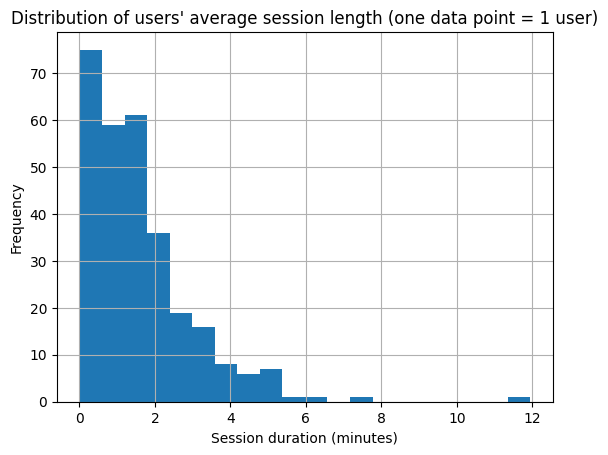

In [25]:
fig, axis = plt.subplots()

avg_session_by_user = (
    sessions
    .groupby("user_id")
    ["duration_mins"]
    .median()
)

_ = (
    avg_session_by_user
    .hist(bins=20, ax=axis)
)

axis.set(
    title="Distribution of users' average session length \
(one data point = 1 user)",
    xlabel="Session duration (minutes)",
    ylabel="Frequency"
)

plt.show()

This chart doesn't look exactly like the one in the slides, but that's because we dropped "closed" events. This might have skewed results somewhat because some sessions might end with a "closed" event.

However, for looking at what time of day people use their phones, we can just look at when sessions started.

### When do users use apps?

Let's look at this at the session level i.e. the hour in which a session began

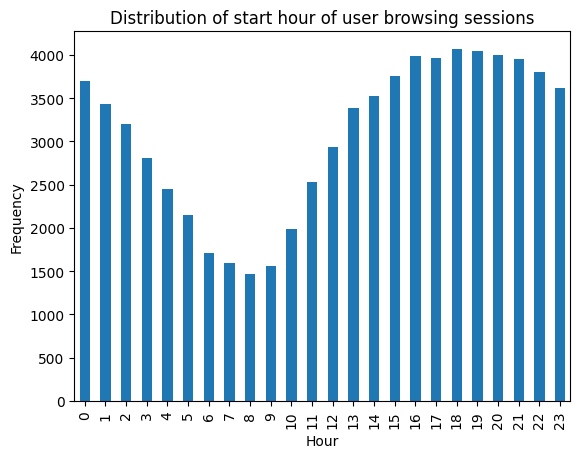

In [26]:
sessions["hour"] = sessions["start"].dt.hour

fig, axis = plt.subplots()

_ = (
    sessions["hour"]
    .value_counts()
    .sort_index()
    .plot(kind="bar", ax=axis)
)

axis.set(
    title="Distribution of start hour of user browsing sessions",
    xlabel="Hour",
    ylabel="Frequency"
)

plt.show()

Interestingly, browsing tapers off between 6-10am then increases throughout the day, peaking in the evening.

Are there users who prefer to browse more in the morning/evening? We can calculate this by looking at the most common "starting hour" for each user and seeing the distribution.

It's possible there's a tie, in that case we'll use *both* values.

In [27]:
def get_modes(group):
    mode_hours = group['hour'].mode()
    return pd.DataFrame(
        {
            'user_id': group['user_id'].iloc[0],
            'most_frequent_hour': mode_hours
        }
    )

most_frequent_hours = (
    sessions
    .groupby("user_id")
    .apply(get_modes)
    .rename(columns={"user_id": "duplicate_user_id"})
    .reset_index()
    .drop(columns=["level_1", "duplicate_user_id"])
)

most_frequent_hours.head()

,user_id,most_frequent_hour
0,0,16
1,0,22
2,1,17
3,2,6
4,3,18


We can just extract the `most_frequent_hour` here and look at its distribution.

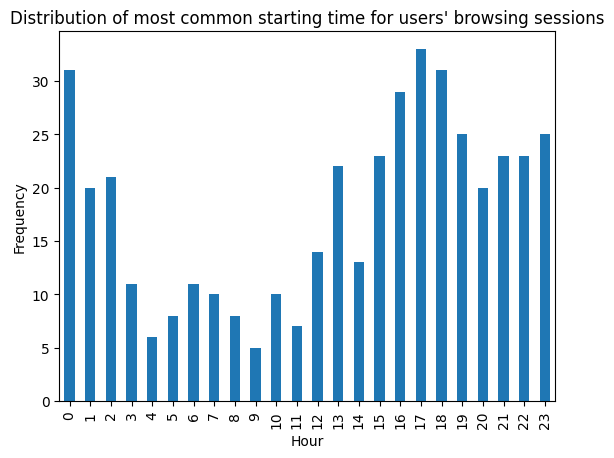

In [28]:
fig, axis = plt.subplots()

_ = (
    most_frequent_hours
    ["most_frequent_hour"]
    .value_counts()
    .sort_index()
    .plot
    .bar(ax=axis)
)

axis.set(
    title="Distribution of most common starting time for users' browsing sessions",
    xlabel="Hour",
    ylabel="Frequency"
)

plt.show()

This is useful! We have people whose most common browsing time is the middle of the night, there's a small peak in the early hours, another around lunchtime, and another in the early evening.

We can use this to categorize people into 4 groups:

- night owl (most common hour is 21-23 or 0-3 inclusive)
- early morning browser (most common hour is 4-9 inclusive)
- midday browser (most common hour is 10-14 inclusive)
- late day browser (most common hour is 15-20 inclusive)

Only problem is users who have an equal number of sessions in two of these categories. To get around that, we can use dummy/indicator variables and just have multiple 1s for users with multiple group membership.

We'll use this `most_frequent_hours` object to find which users should belong in which group.

In [29]:
bins = [-1, 3, 9, 14, 20]
labels = ['night_owl', 'early_morning_browser',
          'midday_browser', 'late_day_browser']

most_frequent_hours["category"] = (
    pd.cut(
        most_frequent_hours["most_frequent_hour"],
        bins=bins,
        labels=labels,
        ordered=True
    )
)

# fix additional night owl values
most_frequent_hours.loc[most_frequent_hours["most_frequent_hour"].isin([21, 22, 23]), "category"] = "night_owl"

most_frequent_hours.head()

,user_id,most_frequent_hour,category
0,0,16,late_day_browser
1,0,22,night_owl
2,1,17,late_day_browser
3,2,6,early_morning_browser
4,3,18,late_day_browser


In [30]:
(
    most_frequent_hours["category"]
    .value_counts()
    .sort_index()
)

night_owl                154
early_morning_browser     48
midday_browser            66
late_day_browser         161
Name: category, dtype: int64

This is the time to start building a user-level dataset anyway, since that's what we'll need to segment our users. This way, we can have users be in multiple categories.

In [31]:
users = (
    pd.get_dummies(
        most_frequent_hours.drop(columns=["most_frequent_hour"]),
        columns=["category"],
        prefix="time"
    )
    .groupby("user_id")
    .max()
    .reset_index()
)

users.head()

,user_id,time_night_owl,time_early_morning_browser,time_midday_browser,time_late_day_browser
0,0,1,0,0,1
1,1,0,0,0,1
2,2,0,1,0,0
3,3,0,0,0,1
4,4,1,0,0,0


### What apps do people use?

We have the app name, but not the categorization. With a little help from ChatGPT we can categorize the apps. First, let's print the app names so it's easier to paste into ChatGPT.

In [32]:
categories = pd.read_csv("./data/App_Categories.csv",
                         skiprows=1,
                         names=["app_name", "app_category"])
print(categories.shape)
categories.head()

(87, 2)


,app_name,app_category
0,Minesweeper Classic (Mines),Mobile Games
1,Gmail,Email
2,Google,Web Browser/Search Engine
3,Instagram,Social Media
4,Google Chrome,Web Browser


In [33]:
categories["app_category"].value_counts()

Messaging                    12
Utility                       9
Social Media                  8
Mobile Games                  5
Unknown                       5
Advertising                   5
Email                         5
Finance                       5
Video Streaming               4
Online Shopping               4
Music Streaming               3
Web Browser                   3
Communication                 3
Photo Management              3
Photo Editing                 2
Web Browser/Search Engine     2
Cloud Storage                 1
Social Media/Messaging        1
Productivity                  1
Note Taking                   1
News                          1
Navigation                    1
Health                        1
Podcasts                      1
App Marketplace               1
Name: app_category, dtype: int64

There are some "Unknown" values in there

In [34]:
categories[categories["app_category"] == "Unknown"]

,app_name,app_category
45,MUIQ Survey App,Unknown
54,Reward Stash,Unknown
68,Movie Play Box,Unknown
70,SurveyCow,Unknown
76,MetroZone,Unknown


In [35]:
categories.loc[categories["app_name"]=="MUIQ Survey App", "app_category"] = "Survey"
categories.loc[categories["app_name"]=="SurveyCow", "app_category"] = "Survey"
categories.loc[categories["app_name"]=="Reward Stash", "app_category"] = "Rewards"
categories.loc[categories["app_name"]=="Movie Play Box", "app_category"] = "Video Streaming"
categories.loc[categories["app_name"]=="MetroZone", "app_category"] = "Utility"

Too many categories. Let's combine them.

In [36]:
for category in sorted(categories["app_category"].unique()):
    print(f"'{category}': '',")

'Advertising': '',
'App Marketplace': '',
'Cloud Storage': '',
'Communication': '',
'Email': '',
'Finance': '',
'Health': '',
'Messaging': '',
'Mobile Games': '',
'Music Streaming': '',
'Navigation': '',
'News': '',
'Note Taking': '',
'Online Shopping': '',
'Photo Editing': '',
'Photo Management': '',
'Podcasts': '',
'Productivity': '',
'Rewards': '',
'Social Media': '',
'Social Media/Messaging': '',
'Survey': '',
'Utility': '',
'Video Streaming': '',
'Web Browser': '',
'Web Browser/Search Engine': '',


In [37]:
categories = categories.rename(columns={"app_category": "app_subcategory"})

category_map = {
    'Advertising': 'Money',
    'App Marketplace': 'Entertainment',
    'Cloud Storage': 'Utility',
    'Communication': 'Social',
    'Email': 'Social',
    'Finance': 'Money',
    'Health': 'Social',
    'Messaging': 'Social',
    'Mobile Games': 'Entertainment',
    'Music Streaming': 'Entertainment',
    'Navigation': 'Utility',
    'News': 'Social',
    'Note Taking': 'Utility',
    'Online Shopping': 'Money',
    'Photo Editing': 'Utility',
    'Photo Management': 'Utility',
    'Podcasts': 'Entertainment',
    'Productivity': 'Utility',
    'Rewards': 'Money',
    'Social Media': 'Social',
    'Social Media/Messaging': 'Social',
    'Survey': 'Money',
    'Utility': 'Utility',
    'Video Streaming': 'Entertainment',
    'Web Browser': 'Browsing',
    'Web Browser/Search Engine': 'Browsing'
}

categories["app_category"] = categories["app_subcategory"].map(category_map)
categories.head()

,app_name,app_subcategory,app_category
0,Minesweeper Classic (Mines),Mobile Games,Entertainment
1,Gmail,Email,Social
2,Google,Web Browser/Search Engine,Browsing
3,Instagram,Social Media,Social
4,Google Chrome,Web Browser,Browsing


Now we can merge this to the main dataset and find people's most common app usage type (e.g. Social)

In [38]:
app_data_merged = app_data_reduced.merge(
    categories,
    on="app_name")
assert len(app_data_reduced) ==  len(app_data_merged)
app_data_merged.head()

,user_id,session_id,timestamp,app_name,event_type,app_subcategory,app_category
0,0,1,2018-01-16 06:01:05,Minesweeper Classic (Mines),Opened,Mobile Games,Entertainment
1,0,1,2018-01-16 06:01:07,Minesweeper Classic (Mines),Opened,Mobile Games,Entertainment
2,0,1,2018-01-16 06:01:08,Minesweeper Classic (Mines),Opened,Mobile Games,Entertainment
3,0,1,2018-01-16 06:01:09,Minesweeper Classic (Mines),Opened,Mobile Games,Entertainment
4,0,1,2018-01-16 06:03:44,Minesweeper Classic (Mines),Opened,Mobile Games,Entertainment


Find each user's most common category

In [39]:
top_categories = (
    app_data_merged
    .groupby("user_id")
    ["app_category"]
    .apply(pd.Series.mode)
    .reset_index()
)

top_categories.head()

,user_id,level_1,app_category
0,0,0,Entertainment
1,1,0,Social
2,2,0,Social
3,3,0,Money
4,4,0,Social


As with times, there may be users with multiple app types as their most common. Let's find them.

In [40]:
top_categories[top_categories["level_1"] > 0]

,user_id,level_1,app_category
36,35,1,Utility
134,132,1,Utility
226,223,1,Social


Just 3 users. Let's examine them in a bit more detail

In [41]:
top_categories[top_categories["user_id"].isin([35, 223, 132])]

,user_id,level_1,app_category
35,35,0,Social
36,35,1,Utility
133,132,0,Social
134,132,1,Utility
225,223,0,Browsing
226,223,1,Social


In [42]:
(
    app_data_merged[app_data_merged["user_id"] == 35]
    .groupby(["app_category", "app_name"])
    .size()
)

app_category   app_name                
Browsing       Google Chrome               21
               Samsung Internet Browser     1
Entertainment  Google Play Store            6
Social         Gmail                       17
               Telegram                     7
Utility        Camera                       4
               Samsung Gallery              5
               Samsung Notes                1
               Settings                    14
dtype: int64

User 35 used the Settings app a bit, but mostly Gmail and browsing. Let's categorize them as "Social" rather than "Utility".

In [43]:
app_data_merged[app_data_merged["user_id"] == 132].groupby(["app_category", "app_name"]).size()

app_category   app_name         
Browsing       Google                1
               Google Chrome         6
Entertainment  Google Play Store     3
               YouTube               3
Social         Messages             15
Utility        Contacts              1
               Google Drive          2
               Maps                  1
               Settings             11
dtype: int64

Again, for user 132, a few instances of Settings but Social is probably a better descriptor for this user.

Let's drop both those Utility records.

In [44]:
top_categories = (
    top_categories
    .drop(
        index=top_categories[
            (top_categories["user_id"].isin([35, 132]))
            & (top_categories["app_category"] == "Utility")
            ].index
    )
)

In [45]:
(
    app_data_merged[app_data_merged["user_id"] == 223]
    .groupby(["app_category", "app_name"])
    .size()
)

app_category   app_name          
Browsing       Google                19
               Google Chrome          3
Entertainment  Google Play Store      9
Social         Facebook               8
               Facebook Messenger     7
               Gmail                  1
               TextNow                6
Utility        Settings               5
dtype: int64

A tie between browsing and social. The "Google" app is not quite as strong a signal for browsing so let's call this user "Social".

In [46]:
top_categories = (
    top_categories
    .drop(
        index=top_categories[
            (top_categories["user_id"] == 223)
            & (top_categories["app_category"] == "Browsing")
            ].index
    )
)

In [47]:
top_categories["user_id"].value_counts().loc[lambda x: x > 1]

Series([], Name: user_id, dtype: int64)

Now, we will turn our "top category" data into one-hot encoded variables so we can use it in a clustering algorithm. We'll also drop that unnecessary `level_1` column.

In [48]:
top_categories = (
    pd.get_dummies(
        top_categories,
        columns=["app_category"]
    ).drop(
        columns=["level_1"]
    )
)

top_categories.head()

,user_id,app_category_Browsing,app_category_Entertainment,app_category_Money,app_category_Social,app_category_Utility
0,0,0,1,0,0,0
1,1,0,0,0,1,0
2,2,0,0,0,1,0
3,3,0,0,1,0,0
4,4,0,0,0,1,0


Join this to our growing user table

In [49]:
size_before = len(users)
users = users.merge(top_categories, on="user_id")
size_after = len(users)
assert size_before == size_after

In [50]:
users.head()

,user_id,time_night_owl,time_early_morning_browser,time_midday_browser,time_late_day_browser,app_category_Browsing,app_category_Entertainment,app_category_Money,app_category_Social,app_category_Utility
0,0,1,0,0,1,0,1,0,0,0
1,1,0,0,0,1,0,0,0,1,0
2,2,0,1,0,0,0,0,0,1,0
3,3,0,0,0,1,0,0,1,0,0
4,4,1,0,0,0,0,0,0,1,0


### Add the other features

We should also include the features that were used initially, namely:

- number of unique apps per user
- average length of user session

Let's also put in "number of unique sessions" as a proxy for frequency.

In [51]:
user_metrics = (
    app_data_merged
    .groupby(["user_id"])
    .agg(
        number_of_apps=("app_name", "nunique"),
        number_of_sessions=("session_id", "nunique")
    )
    .reset_index()
)

user_metrics.head()

,user_id,number_of_apps,number_of_sessions
0,0,19,238
1,1,18,88
2,2,16,61
3,3,15,70
4,4,8,45


Join this to our user data

In [52]:
size_before = len(users)
users = users.merge(user_metrics, on="user_id")
size_after = len(users)
assert size_before == size_after

Now calculate average session time

In [53]:
avg_sessions = (
    sessions
    .groupby("user_id")
    .agg(avg_session_length=("duration_mins", "median"))
    .reset_index()
)

avg_sessions.head()

,user_id,avg_session_length
0,0,0.658333
1,1,1.483333
2,2,0.533333
3,3,0.116667
4,4,0.233333


Finally, join this to the user data

In [54]:
size_before = len(users)
users = users.merge(avg_sessions, on="user_id")
size_after = len(users)
assert size_before == size_after

In [55]:
users.columns

Index(['user_id', 'time_night_owl', 'time_early_morning_browser',
       'time_midday_browser', 'time_late_day_browser', 'app_category_Browsing',
       'app_category_Entertainment', 'app_category_Money',
       'app_category_Social', 'app_category_Utility', 'number_of_apps',
       'number_of_sessions', 'avg_session_length'],
      dtype='object')

In [56]:
users.head()

,user_id,time_night_owl,time_early_morning_browser,time_midday_browser,time_late_day_browser,app_category_Browsing,app_category_Entertainment,app_category_Money,app_category_Social,app_category_Utility,number_of_apps,number_of_sessions,avg_session_length
0,0,1,0,0,1,0,1,0,0,0,19,238,0.658333
1,1,0,0,0,1,0,0,0,1,0,18,88,1.483333
2,2,0,1,0,0,0,0,0,1,0,16,61,0.533333
3,3,0,0,0,1,0,0,1,0,0,15,70,0.116667
4,4,1,0,0,0,0,0,0,1,0,8,45,0.233333


### Export data for clustering in next chapter

In [57]:
users.to_parquet("../chapter-13/data/users.parquet", index=False)